Source: https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial#environment  
  
Needs the conda enviroment 'tfenv' activated

In [45]:
# Libraries
import tensorflow as tf
import numpy as np

from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments.gym_wrapper import GymWrapper
from tf_agents.environments import tf_py_environment
from tf_agents.environments import wrappers
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import random_tf_policy
from tf_agents.policies.fixed_policy import FixedPolicy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.specs.tensor_spec import to_array_spec
from tf_agents.utils import common

# Environment
from envs.discrete_BS_for_tf_agents import BSEnv

**Hyperparameters**

In [46]:
num_iterations = int(1e+4) # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 5  # @param {type:"integer"}
replay_buffer_max_length = 1000000  # @param {type:"integer"}

batch_size = 131072  # @param {type:"integer"}
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2, decay_steps=1000,decay_rate=0.9)#5e-4  # @param {type:"number"}
log_interval = 1000  # @param {type:"integer"}

num_eval_episodes = int(5e+4)  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

target_update_tau=0.05 # @param {type:"float"}
gamma=1.0 # @param {type:"float"}

**Discrete Action Environment**

In [47]:
# Create environment

# Parameters:
# - mu:    risky asset return 
# - sigma: risky asset variance
# - r:     riskless rate
# - T:     investment horizon
# - dt:    time-step size
# - V_0:   initial PF wealth
# - U_2:   utility function for terminal wealth (default: math.log)

# Market parameters
mu = 0.06
sigma = 0.2
r = 0.04
T = 2
dt = 0.5
V_0 = 100

# Number of discrete Actions
num_actions = 10

env = BSEnv(mu=mu, sigma=sigma, r=r, T=T, dt=dt, V_0=V_0)


# Wrapper for creating a PyEnvironment
env = GymWrapper(gym_env=env)
print('Action Spec:', env.action_spec())


# Wrapper for discretising the action space, necessary for the DQN Algorithm
env = wrappers.ActionDiscretizeWrapper(env, num_actions=num_actions)
print('Discretized Action Spec:', env.action_spec())
print(env._discrete_spec)
discrete_actions = np.array(env._action_map, dtype='float32')
print(discrete_actions)


# Wrapper Py Env -> TFPyEnv
env = tf_py_environment.TFPyEnvironment(env)

Action Spec: BoundedArraySpec(shape=(1,), dtype=dtype('float32'), name='action', minimum=-1.0, maximum=1.0)
Discretized Action Spec: BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=9)
BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=9)
[[-1.         -0.7777778  -0.5555556  -0.33333334 -0.11111111  0.11111111
   0.33333334  0.5555556   0.7777778   1.        ]]


**DQN Agent**

In [48]:
fc_layer_params = (64, 64)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
    return tf.keras.layers.Dense(num_units,
                                 activation=tf.keras.activations.relu,
                                 kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.0, 
                                                                 mode='fan_in',
                                                                 distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# it's output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [49]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(time_step_spec=env.time_step_spec(),
                           action_spec=env.action_spec(),
                           q_network=q_net,
                           optimizer=optimizer,
                           target_update_tau=target_update_tau,
                           gamma=gamma,
                           td_errors_loss_fn=common.element_wise_squared_loss,
                           train_step_counter=train_step_counter)

'''Args:
time_step_spec: tf_agents.trajectories.TimeStep,
    action_spec: tf_agents.typing.types.NestedTensorSpec,
    q_network: tf_agents.networks.Network,
    optimizer: tf_agents.typing.types.Optimizer,
    observation_and_action_constraint_splitter: Optional[types.Splitter] = None,
    epsilon_greedy: Optional[types.FloatOrReturningFloat] = 0.1,
    n_step_update: int = 1,
    boltzmann_temperature: Optional[types.FloatOrReturningFloat] = None,
    emit_log_probability: bool = False,
    target_q_network: Optional[tf_agents.networks.Network] = None,
    target_update_tau: tf_agents.typing.types.Float = 1.0,
    target_update_period: int = 1,
    td_errors_loss_fn: Optional[tf_agents.typing.types.LossFn] = None,
    gamma: tf_agents.typing.types.Float = 1.0,
    reward_scale_factor: tf_agents.typing.types.Float = 1.0,
    gradient_clipping: Optional[types.Float] = None,
    debug_summaries: bool = False,
    summarize_grads_and_vars: bool = False,
    train_step_counter: Optional[tf.Variable] = None,
    name: Optional[Text] = None
'''

agent.initialize()

**Policy**

In [50]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

**Metrics and Evaluation**

In [27]:
def compute_avg_return(environment, policy, num_episodes=int(1e+4)):
    print('Evaluating the policy for {} episodes.'.format(num_episodes))
    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

**Compute the average return on a random policy**

In [28]:
random_policy = random_tf_policy.RandomTFPolicy(env.time_step_spec(),
                                                env.action_spec())

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(env, random_policy, num_eval_episodes)
print('Mean utility from terminal wealth (random policy): {}'.format(avg_return))

Evaluating the policy for 50000 episodes.
Mean utility from terminal wealth: 4.6687493324279785


In [44]:
optimal_policy = FixedPolicy(actions=7,
                             time_step_spec = env.time_step_spec(),
                             action_spec=env.action_spec())

# Evaluate the optimal policy
optimal_mean_utility = compute_avg_return(env, optimal_policy, num_eval_episodes)
print('Mean utility from terminal wealth (optimal policy): {}'.format(optimal_mean_utility))

Evaluating the policy for 50000 episodes.
Mean utility from terminal wealth (optimal policy): 4.695707321166992


**Replay buffer**

In [51]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=env.batch_size,
    max_length=replay_buffer_max_length)

**Data Collection**  
Now execute the random policy in the environment for a few steps, recording the data in the replay buffer.

In [52]:
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)

def collect_data(environment, policy, buffer, steps):
    for _ in range(steps):
        collect_step(environment, policy, buffer)

collect_data(env, random_policy, replay_buffer, initial_collect_steps)

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)

**Training the agent**

In [53]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# The average return before training
returns = [avg_return]

for _ in range(num_iterations):

    # Collect a few steps using collect_policy and save to the replay buffer.
    collect_data(env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))
        print('Learning_rate: ', agent._optimizer.learning_rate(step).numpy())

    if step % eval_interval == 0:
        avg_return = compute_avg_return(env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

step = 1000: loss = 0.17406029999256134
Learning_rate:  0.009
Evaluating the policy for 50000 episodes.
step = 1000: Average Return = 4.684001922607422
step = 2000: loss = 0.01897580549120903
Learning_rate:  0.008099999
Evaluating the policy for 50000 episodes.
step = 2000: Average Return = 4.684815406799316
step = 3000: loss = 0.01233480405062437
Learning_rate:  0.007289999
Evaluating the policy for 50000 episodes.
step = 3000: Average Return = 4.688726902008057
step = 4000: loss = 0.014269029721617699
Learning_rate:  0.006560999
Evaluating the policy for 50000 episodes.
step = 4000: Average Return = 4.693101406097412
step = 5000: loss = 0.011494915932416916
Learning_rate:  0.005904899
Evaluating the policy for 50000 episodes.
step = 5000: Average Return = 4.6915717124938965
step = 6000: loss = 0.010752880945801735
Learning_rate:  0.005314409
Evaluating the policy for 50000 episodes.
step = 6000: Average Return = 4.68353796005249
step = 7000: loss = 0.010664835572242737
Learning_rate:

In [54]:
import matplotlib
import matplotlib.pyplot as plt

Text(0.5, 0, 'Iterations')

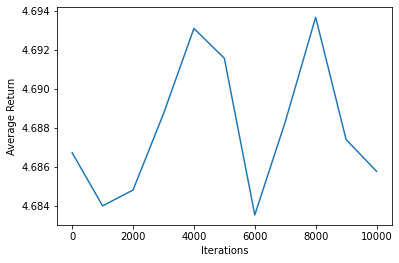

In [55]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
#plt.ylim(top=5)

In [38]:
time_step = env.reset()
print("Observation: \n",time_step.observation.numpy())

while not time_step.is_last():
    action_step = agent.policy.action(time_step)
    time_step = env.step(action_step.action)
    print("Action: \n", action_step)
    print("Observation: \n", time_step.observation.numpy())

Observation: 
 [[  0. 100.]]
Action: 
 PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([9])>, state=(), info=())
Observation: 
 [[  0.5      105.723915]]
Action: 
 PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([5])>, state=(), info=())
Observation: 
 [[  1.      107.93191]]
Action: 
 PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([5])>, state=(), info=())
Observation: 
 [[  1.5      110.853294]]
Action: 
 PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([5])>, state=(), info=())
Observation: 
 [[  2.      112.49285]]


In [19]:
def plot_q_value_surface(agent, discr_actions, times, wealths):
    '''Plots the Action-value function of the critic network learned by the DDPG agent for different points in time
       across wealth and risky asset allocation dimensions.
    
    Args:
        - critic: [tf_agents.critic_network] The used action-value network
        - times: [np.array] A numpy array with points in time to evaluate the action-value function at
        - wealths: [np.array] A numpy array with the wealth levels to be used
        - risky_asset_allocations: [np.array] A numpy array with the inv. in the risky asset to be used
    '''
    
    def _q_values(agent, t, wealths):
        '''
        Returns a numpy array of shape wealths.shape with the respective q_values.

        Args:
            - critic: [tf_agents.critic_network] The used action-value network
            - t: [float] Time to be used as first dimension for the observation [t, wealth]
            - X: [np.ravel(np.meshgrid)] Risky asset allocations
            - Y: [np.ravel(np.meshgrid)] Wealth levels
        '''
        if t == 0:
            return np.array([[agent._q_network(tf.constant([[t, wealth]]), step_type=tf.constant([[0]]),training=False)] for wealth in wealths])
        elif t < T:
            return np.array([[agent._q_network(tf.constant([[t, wealth]]), step_type=tf.constant([[1]]),training=False)] for wealth in wealths])
        else:
            return np.array([[agent._q_network(tf.constant([[t, wealth]]), step_type=tf.constant([[2]]),training=False)] for wealth in wealths]) 
    
    Zs = []
    # Generate a seperate plot for each point in time
    for t in times:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')                        
        X, Y = np.meshgrid(discr_actions, wealths)
        zs = np.array(_q_values(agent=agent, t=t, wealths=np.ravel(Y)))
        Z = zs.reshape(X.shape)
        ax.plot_wireframe(X, Y, Z, color="black")

        ax.set_xlabel('investment in risky asset')
        ax.set_ylabel('wealth')
        ax.set_zlabel('Q-values')
        plt.title("Learned Q-value surface at time t={}".format(t))

        plt.show()
        Zs.append(Z)
    
    return(Zs)

In [72]:
times = np.array([0.0, 0.5, 1.0, 1.5, 2.0], dtype='float32')
wealths = np.arange(50, 200, 5, dtype='float32')

[[[<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[3.9773107, 3.9860425, 3.9966226, 3.988876 , 3.9990597, 4.005432 ,
        4.006585 , 4.0016036, 4.003415 , 4.006079 ]], dtype=float32)>
   ()]]

 [[<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[3.9773107, 3.9860425, 3.9966226, 3.988876 , 3.9990597, 4.005432 ,
        4.006585 , 4.0016036, 4.003415 , 4.006079 ]], dtype=float32)>
   ()]]

 [[<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[3.9773107, 3.9860425, 3.9966226, 3.988876 , 3.9990597, 4.005432 ,
        4.006585 , 4.0016036, 4.003415 , 4.006079 ]], dtype=float32)>
   ()]]

 [[<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[3.9773107, 3.9860425, 3.9966226, 3.988876 , 3.9990597, 4.005432 ,
        4.006585 , 4.0016036, 4.003415 , 4.006079 ]], dtype=float32)>
   ()]]

 [[<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[3.9773107, 3.9860425, 3.9966226, 3.988876 , 3.9990597, 4.005432 ,
        4.006585 , 4.0016036, 4.003415 , 4.006079 ]], 

<ipython-input-71-fa54ecbb82b6>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([[agent._q_network(tf.constant([[t, wealth]]), step_type=tf.constant([[0]]),training=False)] for wealth in wealths])


ValueError: cannot reshape array of size 600 into shape (30,10)

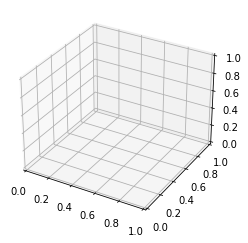

In [73]:
learned_Q_values = plot_q_value_surface(agent, discr_actions=discrete_actions, times=times, wealths=wealths)

In [51]:
q_values, _ = agent._q_network(tf.constant([[1.0, 100.0]]),
                                  step_type=tf.constant([[1]]),
                                  training=False)

In [53]:
print(q_values.numpy())

[[4.622141  4.642992  4.6456046 4.6340137 4.6499023 4.6565557 4.657004
  4.64927   4.656439  4.653376 ]]
